In [6]:
pip install --upgrade tensorflow transformers keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 29.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [1]:
!pip install bert_score
!pip install transformers datasets evaluate sentencepiece
!pip install datasets
!pip install ipywidgets
!pip install evaluate
!pip install accelerate -U
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from datasets import load_dataset

train_dataset = load_dataset("wmt16","de-en", split="train[:50000]")
val_dataset = load_dataset("wmt16","de-en", split="validation")
test_dataset = load_dataset("wmt16","de-en", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [3]:
source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "

def preprocess_function(examples):
    inputs = [prefix + ex['de'] for ex in examples["translation"]]
    targets = [prefix + ex['en'] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

In [4]:
from transformers import DataCollatorForSeq2Seq
from evaluate import load

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

bleu_metric = load("bleu")
meteor_metric = load("meteor")
bertscore_metric = load("bertscore", lang="en")

import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    bleu_score = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_score = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    bertscore_result = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang="en")

    precision = np.mean(bertscore_result['precision'])
    recall = np.mean(bertscore_result['recall'])
    f1 = np.mean(bertscore_result['f1'])

    bertscore_avg = {'precision' : precision, 'recall' : recall, 'f1' : f1}

    return {"bleu": bleu_score, "meteor": meteor_score, "bertscore": bertscore_avg}

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [6]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/Results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,Meteor,Bertscore
1,2.072200,1.787981,"{'bleu': 0.19689889285372303, 'precisions': [0.6578479587604432, 0.4391324996042425, 0.33366195267881427, 0.2533856938378537], 'brevity_penalty': 0.49807047930282394, 'length_ratio': 0.5892704387144079, 'translation_length': 33754, 'reference_length': 57281}",{'meteor': 0.44809845374438273},"{'precision': 0.9198851392751688, 'recall': 0.8992505842444533, 'f1': 0.9092386806819119}"
2,2.018400,1.768904,"{'bleu': 0.19861126465690276, 'precisions': [0.6596582664574018, 0.44272151898734174, 0.3365498963677755, 0.2564742131905216], 'brevity_penalty': 0.4984460683358546, 'length_ratio': 0.5895323056510885, 'translation_length': 33769, 'reference_length': 57281}",{'meteor': 0.45076343684336007},"{'precision': 0.9209321501508952, 'recall': 0.8998377982676441, 'f1': 0.9100548108089019}"


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer is attempting to log a value of "{'bleu': 0.19689889285372303, 'precisions': [0.6578479587604432, 0.4391324996042425, 0.33366195267881427, 0.2533856938378537], 'brevity_penalty': 0.49807047930282394, 'length_ratio': 0.5892704387144079, 'translation_length': 33754, 'reference_length': 57281}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'meteor': 0.44809845374438273}" of type <class 'dict'> for key "eval/meteor" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to lo

TrainOutput(global_step=6250, training_loss=2.133295078125, metrics={'train_runtime': 1383.4108, 'train_samples_per_second': 72.285, 'train_steps_per_second': 4.518, 'total_flos': 2687376416047104.0, 'train_loss': 2.133295078125, 'epoch': 2.0})

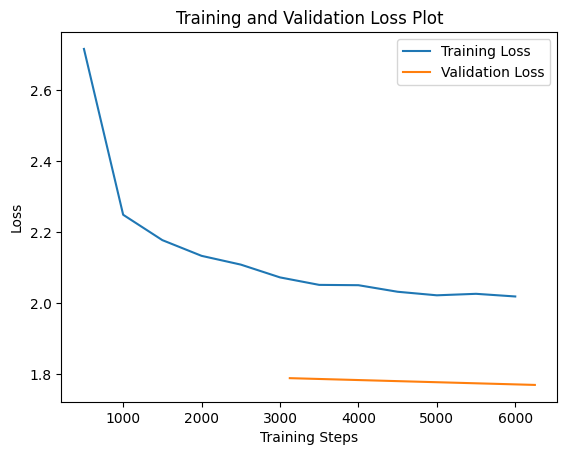

In [7]:
import matplotlib.pyplot as plt

loss_history = trainer.state.log_history

train_losses = [(entry['loss'], entry['step']) for entry in loss_history if 'loss' in entry and 'step' in entry]
eval_losses = [(entry['eval_loss'], entry['step']) for entry in loss_history if 'eval_loss' in entry and 'step' in entry]

train_loss_values, train_loss_steps = zip(*train_losses) if train_losses else ([], [])
eval_loss_values, eval_loss_steps = zip(*eval_losses) if eval_losses else ([], [])

plt.plot(train_loss_steps, train_loss_values, label='Training Loss')
plt.plot(eval_loss_steps, eval_loss_values, label='Validation Loss')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Plot')
plt.show()

In [13]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/Results",
    evaluation_strategy = 'steps',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Bleu,Meteor,Bertscore
500,1.920600,1.752171,"{'bleu': 0.2017094830942005, 'precisions': [0.6635257281266616, 0.44702540634369575, 0.3414080498712563, 0.2603576260650163], 'brevity_penalty': 0.5005734462516511, 'length_ratio': 0.5910162182922785, 'translation_length': 33854, 'reference_length': 57281}",{'meteor': 0.45415968933459},"{'precision': 0.922162023789875, 'recall': 0.900672699268538, 'f1': 0.9110820779551994}"
1000,1.923500,1.746872,"{'bleu': 0.20219616949297428, 'precisions': [0.6652177769892664, 0.4490679304897314, 0.3430344967945456, 0.2616066198008202], 'brevity_penalty': 0.49969766528265536, 'length_ratio': 0.5904051954400238, 'translation_length': 33819, 'reference_length': 57281}",{'meteor': 0.45484315214625737},"{'precision': 0.9226667058803124, 'recall': 0.9008241561273651, 'f1': 0.9114083311644607}"
1500,1.938300,1.739274,"{'bleu': 0.20171735269066804, 'precisions': [0.6645151739452257, 0.449218502815921, 0.34293576111696167, 0.26169869444036964], 'brevity_penalty': 0.4985962897666075, 'length_ratio': 0.5896370524257607, 'translation_length': 33775, 'reference_length': 57281}",{'meteor': 0.45412325241434676},"{'precision': 0.9224234104376337, 'recall': 0.9006780670666376, 'f1': 0.9112146219497125}"
2000,1.931100,1.735581,"{'bleu': 0.20170614124168365, 'precisions': [0.6637946349262747, 0.4487581078943205, 0.3430153553471939, 0.2621850588623611], 'brevity_penalty': 0.49857125342475395, 'length_ratio': 0.589619594629982, 'translation_length': 33774, 'reference_length': 57281}",{'meteor': 0.4535304780413988},"{'precision': 0.9224880962890654, 'recall': 0.9005949175978872, 'f1': 0.9112035895394202}"
2500,1.932700,1.730706,"{'bleu': 0.20189975987033162, 'precisions': [0.6639023812344509, 0.44975470802342143, 0.3437436280840073, 0.26253806361668564], 'brevity_penalty': 0.49832087761685245, 'length_ratio': 0.589445016672195, 'translation_length': 33764, 'reference_length': 57281}",{'meteor': 0.453941620940236},"{'precision': 0.9226226413398363, 'recall': 0.9007206839479681, 'f1': 0.9113328971583594}"
3000,1.909200,1.729636,"{'bleu': 0.20196422834279223, 'precisions': [0.6648991320318749, 0.45001266303659615, 0.3439613854991672, 0.2625321100917431], 'brevity_penalty': 0.4981456011584754, 'length_ratio': 0.5893228121017441, 'translation_length': 33757, 'reference_length': 57281}",{'meteor': 0.4544133396581207},"{'precision': 0.9228021684963619, 'recall': 0.9007411870664032, 'f1': 0.9114319317733268}"
3500,1.897800,1.727629,"{'bleu': 0.20301565228009455, 'precisions': [0.6654937906564163, 0.45098101165839943, 0.3449223254867377, 0.2631347709881741], 'brevity_penalty': 0.4997226914544556, 'length_ratio': 0.5904226532358025, 'translation_length': 33820, 'reference_length': 57281}",{'meteor': 0.4550677552393047},"{'precision': 0.9229396124653356, 'recall': 0.9009903206590025, 'f1': 0.9116245191896385}"
4000,1.905200,1.723213,"{'bleu': 0.2026153950403229, 'precisions': [0.6652152018720934, 0.4515986071541627, 0.3454675231977159, 0.26361367972992805], 'brevity_penalty': 0.49819568127131797, 'length_ratio': 0.5893577276933014, 'translation_length': 33759, 'reference_length': 57281}",{'meteor': 0.45505712845332896},"{'precision': 0.9228514609879863, 'recall': 0.9008980988906572, 'f1': 0.9115352649576601}"
4500,1.895500,1.722579,"{'bleu': 0.20301600140970083, 'precisions': [0.6647046644384631, 0.4513590391908976, 0.3451867937972923, 0.2636070617537177], 'brevity_penalty': 0.49944739110492076, 'length_ratio': 0.5902306174822367, 'translation_length': 33809, 'reference_length': 57281}",{'meteor': 0.45485810265344173},"{'precision': 0.9228422742057033, 'recall': 0.9008679546041387, 'f1': 0.9115139567780571}"
5000,1.891900,1.720480,"{'bleu': 0.2029748040755504, 'precisions': [0.6644978114278954, 0.4511898366147331, 0.34511773088145486, 0.26346822926203994], 'brevity_penalty': 0.499522475736124, 'length_ratio': 0.5902829908695728, 'translation_length': 33812, 'reference_length': 57281}",{'meteor':

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Trainer is attempting to log a value of "{'bleu': 0.2017094830942005, 'precisions': [0.6635257281266616, 0.44702540634369575, 0.3414080498712563, 0.2603576260650163], 'brevity_penalty': 0.5005734462516511, 'length_ratio': 0.5910162182922785, 'translation_length': 33854, 'reference_length': 57281}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'meteor': 0.45415968933459}" of type <class 'dict'> for key "eval/meteor" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{

TrainOutput(global_step=6250, training_loss=1.9121017822265625, metrics={'train_runtime': 1913.645, 'train_samples_per_second': 52.256, 'train_steps_per_second': 3.266, 'total_flos': 2687376416047104.0, 'train_loss': 1.9121017822265625, 'epoch': 2.0})

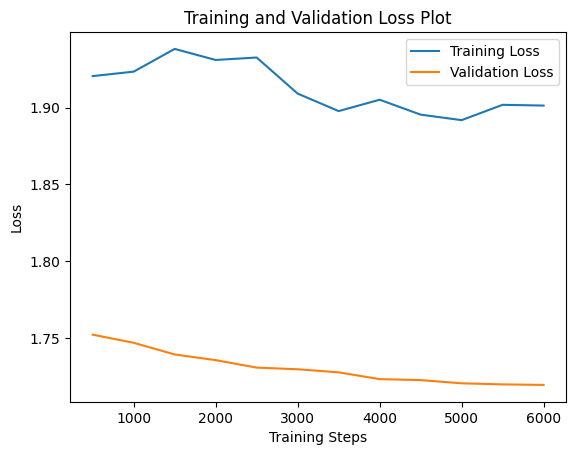

In [14]:
import matplotlib.pyplot as plt

loss_history = trainer.state.log_history

train_losses = [(entry['loss'], entry['step']) for entry in loss_history if 'loss' in entry and 'step' in entry]
eval_losses = [(entry['eval_loss'], entry['step']) for entry in loss_history if 'eval_loss' in entry and 'step' in entry]

train_loss_values, train_loss_steps = zip(*train_losses) if train_losses else ([], [])
eval_loss_values, eval_loss_steps = zip(*eval_losses) if eval_losses else ([], [])

plt.plot(train_loss_steps, train_loss_values, label='Training Loss')
plt.plot(eval_loss_steps, eval_loss_values, label='Validation Loss')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Plot')
plt.show()

In [8]:
res = trainer.evaluate(eval_dataset=test_dataset)
print(res)

Trainer is attempting to log a value of "{'bleu': 0.20806418880341337, 'precisions': [0.667850610404526, 0.45802948726686205, 0.3504875670404681, 0.26829909786696826], 'brevity_penalty': 0.505220761309583, 'length_ratio': 0.5942618806875632, 'translation_length': 47018, 'reference_length': 79120}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'meteor': 0.45818509565319604}" of type <class 'dict'> for key "eval/meteor" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9201735087178794, 'recall': 0.8987075565615746, 'f1': 0.9091028578283787}" of type <class 'dict'> for key "eval/bertscore" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.640112042427063, 'eval_bleu': {'bleu': 0.20806418880341337, 'precisions': [0.667850610404526, 0.45802948726686205, 0.3504875670404681, 0.26829909786696826], 'brevity_penalty': 0.505220761309583, 'length_ratio': 0.5942618806875632, 'translation_length': 47018, 'reference_length': 79120}, 'eval_meteor': {'meteor': 0.45818509565319604}, 'eval_bertscore': {'precision': 0.9201735087178794, 'recall': 0.8987075565615746, 'f1': 0.9091028578283787}, 'eval_runtime': 72.5975, 'eval_samples_per_second': 41.31, 'eval_steps_per_second': 2.59, 'epoch': 2.0}


In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
import pandas as pd
import csv
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer

file_path = '/content/drive/MyDrive/Results/checkpoint-6000'

model = AutoModelForSeq2SeqLM.from_pretrained(file_path)

tokenizer = AutoTokenizer.from_pretrained(file_path)

translator = pipeline("translation", model=model, tokenizer= tokenizer)

def translate(text):
    translation = translator(text)
    translated_text = translation[0]['translation_text']
    return translated_text

def translate_csv(input_path, output_path):
    with open(input_path, mode='r', newline='', encoding='utf-8') as infile, \
         open(output_path, mode='w', newline='', encoding='utf-8') as outfile:

        reader = csv.DictReader(infile)
        writer = csv.DictWriter(outfile, fieldnames=['de', 'en'])
        writer.writeheader()

        for row in reader:
            german_text = row['de']
            english_text = translate(german_text)
            writer.writerow({'de': german_text, 'en': english_text[29:]})

input_csv_path = '/content/german_lines.csv'
output_csv_path = '/content/translated_lines.csv'
translate_csv(input_csv_path, output_csv_path)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1086: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(
